# Predicting Titanic Survival


## Importing modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf

## Setting up Spark

In [4]:
spark = SparkSession \
    .builder \
    .getOrCreate()

## Importing the dataset

In [5]:
df = spark.read.option("header", "true").option("inferSchema", "true").csv('titanic.csv').cache()
df.createOrReplaceTempView('df')
df.show(10)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

### Some people's age is missing in the database, so we delete rows with missing values.

In [6]:
#df = df.fillna(round(df.select(avg("Age")).collect()[0][0], 1), 'Age')
# Replacing all 'null' values with the average age decreased the accuracy.

df = df.where(col("Age").isNotNull())
df.show(10)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          7|       0|     1|McCarthy, Mr. Tim...|  male|54.0|    0|    0|      

### We get rid of columns 'Name' (irrelevant), 'Ticket' (unstructured) and 'Cabin' (incomplete)

In [7]:
df = df.drop('Name', 'Ticket', 'Cabin')
df.show(5)

+-----------+--------+------+------+----+-----+-----+-------+--------+
|PassengerId|Survived|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|
+-----------+--------+------+------+----+-----+-----+-------+--------+
|          1|       0|     3|  male|22.0|    1|    0|   7.25|       S|
|          2|       1|     1|female|38.0|    1|    0|71.2833|       C|
|          3|       1|     3|female|26.0|    0|    0|  7.925|       S|
|          4|       1|     1|female|35.0|    1|    0|   53.1|       S|
|          5|       0|     3|  male|35.0|    0|    0|   8.05|       S|
+-----------+--------+------+------+----+-----+-----+-------+--------+
only showing top 5 rows



### 2 rows are missing 'Embarked' data. We can't do anything with missing values, so we just delete those rows

In [8]:
df.groupBy("Embarked").count().show()
df = df.where(col("Embarked").isNotNull())

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   28|
|    null|    2|
|       C|  130|
|       S|  554|
+--------+-----+



## Graphs

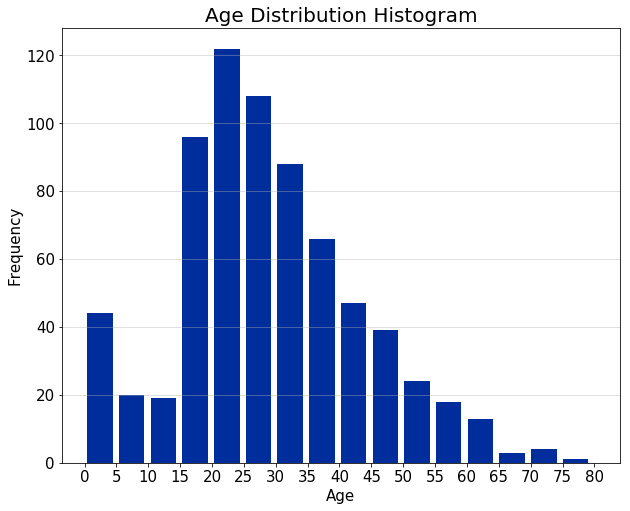

In [9]:
%matplotlib inline
age = df.select("Age").rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=[10,8])
plt.hist(age, width = 4, color='#002d9c', bins=16)
plt.grid(axis='y', alpha=0.5)
plt.xlabel('Age',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(range(0,85, 5),fontsize=15)
plt.yticks(fontsize=15)
plt.title('Age Distribution Histogram',fontsize=20)
plt.show()

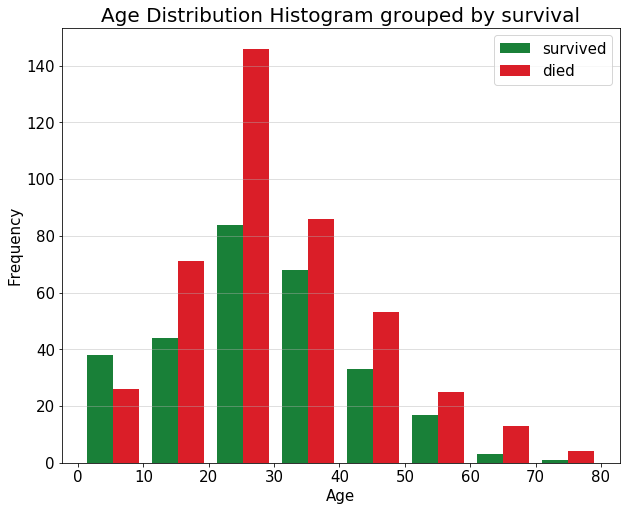

In [10]:
age = df.select("Age").rdd.flatMap(lambda x: x).collect()
survived = df.select("Survived").rdd.flatMap(lambda x: x).collect()

smdf = pd.DataFrame({'a':age, 's':survived})
grouped = smdf.groupby('s')

plt.figure(figsize=[10,8])
plt.grid(axis='y', alpha=0.5)
plt.xlabel('Age',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(range(0,85, 10),fontsize=15)
plt.yticks(fontsize=15)
plt.title('Age Distribution Histogram grouped by survival',fontsize=20)
colors = ['#da1e28', '#198038']
gr = []
for group in grouped:
    gr.append(group)

plt.hist([gr[1][1].a,gr[0][1].a], bins=8, label=['survived', 'died'], color=['#198038','#da1e28'], density = False)

plt.legend(loc='upper right',fontsize=15)
plt.show()

In [ ]:
sex = df.select("Sex").rdd.flatMap(lambda x: x).collect()
survived = df.select("Survived").rdd.flatMap(lambda x: x).collect()

smdf = pd.DataFrame({'sex':sex, 's':survived})
grouped = smdf.groupby('sex')

plt.figure(figsize=[10,8])
plt.grid(axis='y', alpha=0.5)
plt.ylabel('Frequency',fontsize=15)
plt.xticks([0.165, 0.835],['survived','died'],fontsize=15)
plt.yticks(fontsize=15)
plt.title('Survival Distribution Histogram grouped by gender',fontsize=20)
colors = ['#da1e28', '#198038']
gr = []
for group in grouped:
    gr.append(group)

bins = np.linspace(0,1,4)


plt.hist([gr[1][1].s,gr[0][1].s], bins, label=['Female', 'Male'], color=['#ee5396','#4589ff'], density = False)

plt.legend(loc='upper right',fontsize=15)
plt.show()

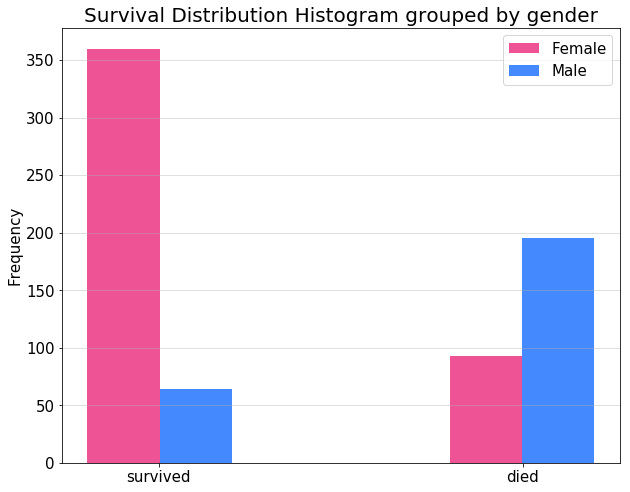

In [11]:
## Feature Extraction

## Feature Extraction

In [12]:
### gender string to numeral (male = 0, female = 1)
genderIndexer = StringIndexer(inputCol="Sex", outputCol="indexedSex")
# embarked string to numeral (S = 0, C = 1, Q = 2)
embarkIndexer = StringIndexer(inputCol="Embarked", outputCol="indexedEmbarked")
# features vector
assembler = VectorAssembler(inputCols=["Pclass","indexedSex","Age","SibSp","Parch","Fare","indexedEmbarked"],outputCol="features")
# standardising features
minmaxscaler = MinMaxScaler(inputCol="features", outputCol="features_minmax")

# put everything in a pipeline
pipeline = Pipeline(stages=[genderIndexer, embarkIndexer, assembler, minmaxscaler])

model = pipeline.fit(df).transform(df)

# some features vectors are transformed to a sparse vector, so we make them dense.
toDense = lambda v: Vectors.dense(v.toArray())
toDenseUdf = udf(toDense, VectorUDT())
model = model.withColumn('features_minmax', toDenseUdf('features_minmax'))

model.show(10)

+-----------+--------+------+------+----+-----+-----+-------+--------+----------+---------------+--------------------+--------------------+
|PassengerId|Survived|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|indexedSex|indexedEmbarked|            features|     features_minmax|
+-----------+--------+------+------+----+-----+-----+-------+--------+----------+---------------+--------------------+--------------------+
|          1|       0|     3|  male|22.0|    1|    0|   7.25|       S|       0.0|            0.0|[3.0,0.0,22.0,1.0...|[1.0,0.0,0.271173...|
|          2|       1|     1|female|38.0|    1|    0|71.2833|       C|       1.0|            1.0|[1.0,1.0,38.0,1.0...|[0.0,1.0,0.472229...|
|          3|       1|     3|female|26.0|    0|    0|  7.925|       S|       1.0|            0.0|[3.0,1.0,26.0,0.0...|[1.0,1.0,0.321437...|
|          4|       1|     1|female|35.0|    1|    0|   53.1|       S|       1.0|            0.0|[1.0,1.0,35.0,1.0...|[0.0,1.0,0.434531...|
|          5|       

## Discarding unnesessary columns

In [13]:
dataset = model.select(['PassengerId', 'Survived', 'features_minmax'])
dataset.show(20)

+-----------+--------+--------------------+
|PassengerId|Survived|     features_minmax|
+-----------+--------+--------------------+
|          1|       0|[1.0,0.0,0.271173...|
|          2|       1|[0.0,1.0,0.472229...|
|          3|       1|[1.0,1.0,0.321437...|
|          4|       1|[0.0,1.0,0.434531...|
|          5|       0|[1.0,0.0,0.434531...|
|          7|       0|[0.0,0.0,0.673284...|
|          8|       0|[1.0,0.0,0.019854...|
|          9|       1|[1.0,1.0,0.334003...|
|         10|       1|[0.5,1.0,0.170645...|
|         11|       1|[1.0,1.0,0.044986...|
|         12|       1|[0.0,1.0,0.723548...|
|         13|       0|[1.0,0.0,0.246041...|
|         14|       0|[1.0,0.0,0.484795...|
|         15|       0|[1.0,1.0,0.170645...|
|         16|       1|[0.5,1.0,0.685850...|
|         17|       0|[1.0,0.0,0.019854...|
|         19|       0|[1.0,1.0,0.384267...|
|         21|       0|[0.5,0.0,0.434531...|
|         22|       1|[0.5,0.0,0.421965...|
|         23|       1|[1.0,1.0,0

## Splitting into training and validation datasets

In [14]:
training, validation = dataset.randomSplit([0.8, 0.2], seed=42)
print(training.count())
print(validation.count())

598
114


## Logistic Regression model

In [15]:
lr = LogisticRegression(labelCol='Survived', featuresCol='features_minmax', maxIter=20)
lr_model = lr.fit(training)
lr_pred = lr_model.transform(validation)
lr_pred.show(5)

+-----------+--------+--------------------+--------------------+--------------------+----------+
|PassengerId|Survived|     features_minmax|       rawPrediction|         probability|prediction|
+-----------+--------+--------------------+--------------------+--------------------+----------+
|          3|       1|[1.0,1.0,0.321437...|[-0.5054849696873...|[0.37625254900139...|       1.0|
|          8|       0|[1.0,0.0,0.019854...|[1.92111426549215...|[0.87226263723811...|       0.0|
|         10|       1|[0.5,1.0,0.170645...|[-2.0730825343503...|[0.11174071607601...|       1.0|
|         15|       0|[1.0,1.0,0.170645...|[-1.0896517075517...|[0.25168386980555...|       1.0|
|         23|       1|[1.0,1.0,0.183211...|[-1.0733657860876...|[0.25476353184897...|       1.0|
+-----------+--------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [16]:
evaluator = MulticlassClassificationEvaluator(
    predictionCol="prediction", 
    labelCol="Survived", 
    metricName="accuracy")

In [17]:
lr_result = evaluator.evaluate(lr_pred)

print('Logistic Regression accuracy: {}%'.format(str(round(lr_result*100,2))))

Logistic Regression accuracy: 78.07%


## Decision Tree

In [18]:
dt = DecisionTreeClassifier(labelCol='Survived', featuresCol='features_minmax', maxDepth=3)
dt_model = dt.fit(training)
dt_pred = dt_model.transform(validation)
dt_pred.show(5)

+-----------+--------+--------------------+-------------+--------------------+----------+
|PassengerId|Survived|     features_minmax|rawPrediction|         probability|prediction|
+-----------+--------+--------------------+-------------+--------------------+----------+
|          3|       1|[1.0,1.0,0.321437...|  [28.0,37.0]|[0.43076923076923...|       1.0|
|          8|       0|[1.0,0.0,0.019854...|   [10.0,1.0]|[0.90909090909090...|       0.0|
|         10|       1|[0.5,1.0,0.170645...|  [8.0,123.0]|[0.06106870229007...|       1.0|
|         15|       0|[1.0,1.0,0.170645...|  [28.0,37.0]|[0.43076923076923...|       1.0|
|         23|       1|[1.0,1.0,0.183211...|  [28.0,37.0]|[0.43076923076923...|       1.0|
+-----------+--------+--------------------+-------------+--------------------+----------+
only showing top 5 rows



In [19]:
dt_result = evaluator.evaluate(dt_pred)

print('Decision Tree accuracy: {}%'.format(str(round(dt_result*100,2))))

Decision Tree accuracy: 85.09%


## Random Forest

In [20]:
rf = RandomForestClassifier(numTrees=1, maxDepth=2, labelCol='Survived', featuresCol='features_minmax', seed=42)
rf_model = rf.fit(training)
rf_pred = rf_model.transform(validation)
rf_pred.show(5)

+-----------+--------+--------------------+--------------------+--------------------+----------+
|PassengerId|Survived|     features_minmax|       rawPrediction|         probability|prediction|
+-----------+--------+--------------------+--------------------+--------------------+----------+
|          3|       1|[1.0,1.0,0.321437...|[0.55696202531645...|[0.55696202531645...|       0.0|
|          8|       0|[1.0,0.0,0.019854...|[0.77057356608478...|[0.77057356608478...|       0.0|
|         10|       1|[0.5,1.0,0.170645...|       [0.056,0.944]|       [0.056,0.944]|       1.0|
|         15|       0|[1.0,1.0,0.170645...|[0.55696202531645...|[0.55696202531645...|       0.0|
|         23|       1|[1.0,1.0,0.183211...|[0.55696202531645...|[0.55696202531645...|       0.0|
+-----------+--------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [21]:
rf_result = evaluator.evaluate(rf_pred)

print('Random Forest accuracy: {}%'.format(str(round(rf_result*100,2))))

Random Forest accuracy: 84.21%
